<a href="https://colab.research.google.com/github/nirjar018/Image-Segmentation/blob/main/Progressive_Resizing_EfficientNet-b7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install mlflow
!pip install pytorch-lightning
!pip install --upgrade pytorch-lightning
!pip install pyngrok
!pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [2]:
from google.colab import files
files.upload()

import os
import zipfile

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d intelecai/car-segmentation

# Unzip the downloaded dataset
!unzip car-segmentation.zip -d /kaggle/car-segmentation

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/intelecai/car-segmentation
License(s): other
 99% 438M/442M [00:05<00:00, 112MB/s]
100% 442M/442M [00:05<00:00, 82.7MB/s]
Archive:  car-segmentation.zip
  inflating: /kaggle/car-segmentation/car-segmentation/classes.txt  
  inflating: /kaggle/car-segmentation/car-segmentation/images/003.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618339-super-purple-modern-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618639-modern-pale-blue-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/156551_preview.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/178583_Side_Profile_Web.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/1965-Shelby-Cobra-Roadster-Side-Profile.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/2008-Morgan-Life-Car-Side-Speed-1024x768.png  
  infl

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from fastai.vision.all import *
from fastai.data.transforms import get_image_files
from tqdm import tqdm
import torchmetrics
import mlflow
import mlflow.pytorch
import mlflow.fastai
import subprocess
from pyngrok import ngrok,conf
import getpass
import albumentations as A
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [3]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///mlflow.db"])

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("SMP_Progressive_Resizing")

print("Enter your authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

Enter your authtoken
··········
 * ngrok tunnel "https://f75d-34-16-190-37.ngrok-free.app" -> "http://127.0.0.1:5000"


In [4]:
!pip install pytorch-lightning==1.5.10

In [5]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
ROOT_DIR = '/kaggle/car-segmentation/car-segmentation'
image_path = Path(ROOT_DIR) / 'images'
mask_path = Path(ROOT_DIR) / 'masks'
codes = ['background', 'car', 'wheels', 'light', 'windows']

class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(self.image_dir))
        self.mask_list = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __getitem__(self, index):
        img_path = str(self.image_dir / self.image_list[index])
        mask_path = str(self.mask_dir / self.mask_list[index])

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        mask = mask.long()
        return img, mask

    def __len__(self):
        return len(self.image_list)

def get_dataloaders(size, batch_size=2):
    transform = A.Compose([
        A.Resize(size, size),
        A.PadIfNeeded(min_height=size, min_width=size,
                      border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    car_data = CarDataset(image_path, mask_path, transform=transform)
    train_size = int(0.8 * len(car_data))
    val_size = len(car_data) - train_size
    train_data, val_data = random_split(car_data, [train_size, val_size])
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_loader_64, val_loader_64 = get_dataloaders(64)
train_loader_128, val_loader_128 = get_dataloaders(128)
train_loader_256, val_loader_256 = get_dataloaders(256)


In [9]:
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
import segmentation_models_pytorch as smp
import mlflow
import mlflow.pytorch

class SegmentationModel(LightningModule):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.model = smp.Unet(encoder_name="efficientnet-b7", encoder_weights="imagenet", in_channels=3, classes=5)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.metric = torchmetrics.Dice(num_classes=5, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks)
        self.log('train_loss', loss, on_step=True, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, masks)
        outputs = torch.argmax(outputs, dim=1)
        score = self.metric(outputs, masks)
        self.log('val_loss', loss, on_step=True, prog_bar=True, on_epoch=True)
        self.log('val_dice', score, on_step=True, prog_bar=True, on_epoch=True)
        return {'val_loss': loss, 'val_dice': score}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# def dice_score(pred, target, smooth=1.):
#     pred = torch.sigmoid(pred)
#     pred = (pred > 0.5).float()
#     intersection = (pred * target).sum()
#     return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


In [10]:
def train_model(train_loader, val_loader, epochs=30, model=None):
    if model is None:
        model = SegmentationModel()
    trainer = Trainer(max_epochs=epochs, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
    mlflow.pytorch.autolog()

    with mlflow.start_run() as run:
        trainer.fit(model, train_loader, val_loader)
        mlflow.pytorch.log_model(model, "model")
    return model

# Train on 64x64 images
model_64 = train_model(train_loader_64, val_loader_64, epochs=30)

# Fine-tune on 128x128 images using 64x64 weights
model_128 = train_model(train_loader_128, val_loader_128, epochs=30, model=model_64)

# Fine-tune on 256x256 images using 128x128 weights
model_256 = train_model(train_loader_256, val_loader_256, epochs=30, model=model_128)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 317MB/s]
INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
2024/07/14 02:52:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/07/14 02:52:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/pytorch/_lightning_autolog.py:463: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.9.0 and

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2024/07/14 03:17:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/14 03:18:13 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.26+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.26' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/14 03:18:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local versi

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2024/07/14 03:49:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/14 03:49:50 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.26+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.26' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/14 03:50:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local versi

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2024/07/14 04:22:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/14 04:22:55 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.26+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.26' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/14 04:23:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local versi

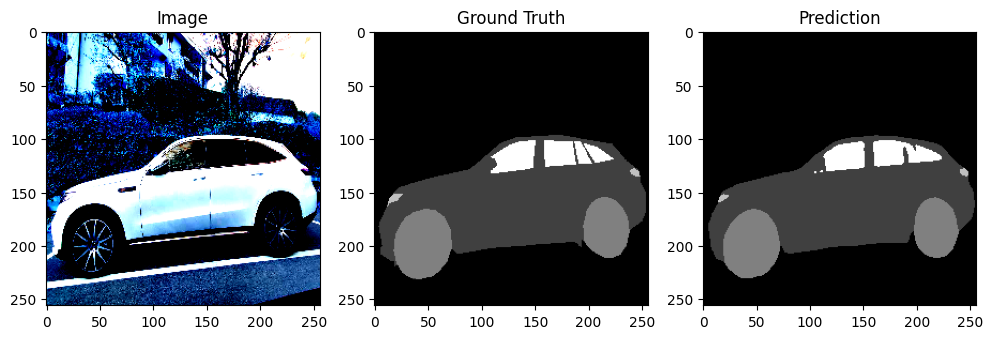

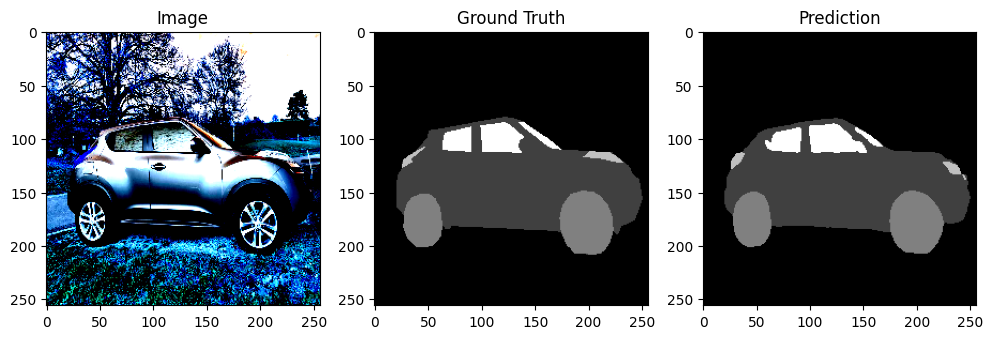

In [14]:
def show_results(model, loader):
    model.eval()
    batch = next(iter(loader))
    images, masks = batch
    with torch.no_grad():
        preds = model(images)

    preds = torch.argmax(preds, dim=1).cpu().numpy()

    for img, mask, pred in zip(images, masks, preds):
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img.permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Image")
        ax[1].imshow(mask.cpu().numpy(), cmap="gray")
        ax[1].set_title("Ground Truth")
        ax[2].imshow(pred, cmap="gray")
        ax[2].set_title("Prediction")
        plt.show()

show_results(model_256, val_loader_256)
